In [498]:
import numpy as np
import math
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import csv
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

# Wczytywanie i przetwarzanie danych

In [345]:
def splitData(data, ratio):
    np.random.shuffle(data)
    train_size = int(len(data) * ratio)
    train_set = data[:train_size]
    test_set = data[train_size:]
    return train_set, test_set

In [346]:
def timeToMinutes(time):
    splitted = time.split(":")
    if int(splitted[0]) > 23 or int(splitted[1]) > 59:
        raise ValueError
    return int(splitted[0]) * 60 + int(splitted[1])

In [347]:
def processTime(time):
    minutes = timeToMinutes(time)
    return  math.sin(minutes / (24 * 60)*math.pi)

In [348]:
def loadData(codesToIndexes):
    data = []
    for i in range(1, 70):
        filePrefix = 'Diabetes-Data/data-'
        if i < 10:
            filePrefix += '0'
        fileHandle = open(filePrefix+str(i), 'r')
        for line in fileHandle:
            line = line.strip()
            if line:
                try:
                    parts = line.split('\t')
                    time = processTime(parts[1])
                    code = int(parts[2])
                    if code not in codesToIndexes.keys():
                        raise ValueError
                    number = int(parts[3])
                    data.append([time, code, number])
                except ValueError:
                    pass
                except IndexError:
                    pass
        
        fileHandle.close()
    return data


In [349]:
def encodeOutput(Y,codesToIndexes):
    Y_encoded = np.zeros((Y.shape[0], 20))
    for i, code in enumerate(Y):
        index = codesToIndexes[code]
        Y_encoded[i, index] = 1
    return Y_encoded

In [350]:
def getEncodedDatasets():
    codesToIndexes = {33:0, 34:1, 35:2, 48:3, 57:4, 58:5, 59:6, 60:7, 61:8, 62:9, 63:10, 64:11, 65:12, 66:13, 67:14, 68:15, 69:16, 70:17, 71:18, 72:19}
    data = np.array(loadData(codesToIndexes))
    train, test = splitData(data, 0.8)
    X_train = train[:, [0, 2]]
    X_test = test[:, [0, 2]]
    Y_train = train[:, 1]
    Y_test = test[:, 1]
    Y_train_encoded = encodeOutput(Y_train,codesToIndexes)
    Y_test_encoded = encodeOutput(Y_test,codesToIndexes)
    return X_test, Y_test_encoded, X_train, Y_train_encoded

# Inicjalizacja parametrów sieci
## Argumenty funkcji:
- `nX` - ilość wejść sieci,
- `nH` - ilość neuronów w warstwach ukrytych, jeśli > 1 argument ten powinien być listą zawierającą kolejne ilości neuronów,
- `nY` - ilość wyjść sieci
- `numberOfHiddenLayers` - ilość neuronów w warstwie ukrytej - musi zgadzać się z nH.
### Zwraca mapę parametrów

In [351]:
def initializeParameters(nX, nH, nY, numberOfHiddenLayers=1):
    parameters = {}
    if numberOfHiddenLayers < 1:
        raise ValueError   
    if numberOfHiddenLayers == 1:
        parameters["W1"] = np.random.randn(nX, nH)
        parameters["b1"] = np.zeros((1,nH))
    if numberOfHiddenLayers > 1:
        parameters["W1"] = np.random.randn(nX, nH[0])
        parameters["b1"] = np.zeros((1,nH[0]))
        for i in range(2, numberOfHiddenLayers+1):
            parameters["W"+str(i)] = np.random.randn(nH[i-2], nH[i-1])
            parameters["b"+str(i)] = np.zeros((1,nH[i-1]))
    if numberOfHiddenLayers == 1:
        parameters["W"+str(numberOfHiddenLayers+1)] = np.random.randn(nH, nY)
    else:
        parameters["W"+str(numberOfHiddenLayers+1)] = np.random.randn(nH[-1], nY)
    parameters["b"+str(numberOfHiddenLayers+1)] = np.zeros((1,nY))
    return parameters

### Funkcje aktywacji

- **Warstwy ukryte:** Sigmoid
  - $$\sigma(z) = \frac{1}{1 + e^{-z}}$$
- **Warstwa wyjściowa:** Softmax
  - $$\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$

### Propagacja w przód

Dla każdej warstwy l (od 1 do L+1, gdzie L+1 to warstwa wyjściowa):

1. **Sygnał wejściowy:** $$Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$$
2. **Aktywacja:** 
   - Dla warstw ukrytych: $$A^{[l]} = \sigma(Z^{[l]})$$
   - Dla warstwy wyjściowej: $$A^{[L+1]} = \text{Softmax}(Z^{[L+1]})$$

### Wsteczna propagacja błędu

1. **Błąd na wyjściu (warstwa L+1):**
   - $$\delta^{[L+1]} = A^{[L+1]} - Y$$

Dla każdej warstwy l od L do 1:

2. **Błąd dla warstwy l:**
   - $$\delta^{[l]} = (W^{[l+1]T} \delta^{[l+1]}) \odot \sigma'(Z^{[l]})$$
3. **Gradient dla wag i biasów:**
   - $$\nabla W^{[l]} = \delta^{[l]} A^{[l-1]T}$$
   - $$\nabla b^{[l]} = \sum(\delta^{[l]}, \text{axis} = 0)$$



In [352]:
def costFunction(Y, Y_hat):
    return - np.sum(Y * np.log(Y_hat))

In [353]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

In [354]:
def softmax(Z):
    return np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)

In [355]:
def propagate(X, Y, parameters):          
    A = X
    history = {"A0": X}
    gradients = {}
    for i in range(1, len(parameters)//2+1):
        Z = np.dot(A, parameters["W"+str(i)]) + parameters["b"+str(i)]
        history["Z"+str(i)] = Z
        if i != len(parameters)//2:
            A = sigmoid(Z)
        else:
            A = softmax(Z)
        history["A"+str(i)] = A
    
    cost = costFunction(Y, A)
    gradients = {}
    
    for i in range(len(parameters)//2, 0, -1):
        if i == len(parameters)//2:
            history["dA"+str(i)]= history["A"+str(i)] - Y
        else:
            history["dA"+str(i)] = np.dot(history["dA"+str(i+1)], parameters["W"+str(i+1)].T) * history["A"+str(i)] * (1 - history["A"+str(i)])
        
        gradients["dW"+str(i)] = np.dot(history["A"+str(i-1)].T,history["dA"+str(i)])
        gradients["db"+str(i)] = np.sum(history["dA"+str(i)], axis=0)
    # if len(parameters)//2 == 1:

    #     Z1 = np.dot(X, parameters["W1"]) + parameters["b1"]
    #     A1 = sigmoid(Z1)
    #     Z2 = np.dot(A1, parameters["W2"]) + parameters["b2"]
    #     A2 = softmax(Z2)
    #     cost = costFunction(Y, A2)
    #     # # pochodne funkcji straty:
    #     dA2 = A2 - Y
    #     dW2 = np.dot(A1.T,dA2) 
    #     db2 = np.sum(dA2, axis=0,keepdims=True)
    #     dA1 = np.dot(dA2, parameters["W2"].T)
    #     dZ1 = dA1 * (A1 * (1 - A1))
    #     dW1 = np.dot(X.T, dZ1)
    #     db1 = np.sum(dZ1, axis=0)
    #     gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return gradients, cost


### Aktualizacja wag

- Wagi i biasy są aktualizowane za pomocą metody spadku gradientu:
  - $$W^{[l]} = W^{[l]} - \alpha \nabla W^{[l]}$$
  - $$b^{[l]} = b^{[l]} - \alpha \nabla b^{[l]}$$

In [356]:
def updateParameters(parameters, gradients, learningRate):
    for key in parameters.keys():
        parameters[key] += - learningRate * gradients["d"+key]
    return parameters

In [357]:
def optimize(X, Y, parameters, learningRate, numberOfIterations, printCost=False):
    costs = []
    for i in range(numberOfIterations):
        gradients, cost = propagate(X, Y, parameters)
        parameters = updateParameters(parameters, gradients, learningRate)
        costs.append(cost)
        if i % 100 == 0 and printCost:
            print("Cost after iteration {}: {}".format(i, cost))
    return parameters, costs

In [358]:
def predict(X, parameters):
    Z = X
    for i in range(1, len(parameters)//2):
        Z = np.dot(Z, parameters["W"+str(i)]) + parameters["b"+str(i)]
        Z = sigmoid(Z)
    Z = np.dot(Z, parameters["W"+str(len(parameters)//2)]) + parameters["b"+str(len(parameters)//2)]
    Z = softmax(Z)
    return Z

In [544]:
def writeFileHeader(fileHandle):
    # headers = ['Alpha', 'nH', 'Cost','Iterations', 'Test Accuracy', 'Macro Test Precision', 'Macro Test Recall', 'Macro Test F1-Score', 
    #     'Macro Test Support','Weighted Test Accuracy', 'Weighted Test Precision', 'Weighted Test Recall', 'Weighted Test F1-Score', 'Weighted Test Support',
    #     'Train Accuracy', 'Macro Train Precision', 'Macro Train Recall', 'Macro Train F1-Score', 'Macro Train Support',
    #     'Weighted Train Accuracy', 'Weighted Train Precision', 'Weighted Train Recall', 'Weighted Train F1-Score', 'Weighted Train Support'
    # ]
    headers = ['Alpha', 'nH', 'Cost','Iterations', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score', 'Test Support',
        'Train Accuracy', 'Train Precision', 'Train Recall', 'Train F1-Score', 'Train Support'
    ]
    writer = csv.writer(fileHandle)
    writer.writerow(headers)

In [545]:
def appendRow(filehandle, test, train, alpha, nH, cost, numberOfIterations):
    row = [
        alpha, nH, cost, numberOfIterations,
        test['accuracy'], test['weighted avg']['precision'], test['weighted avg']['recall'], test['weighted avg']['f1-score'], test['weighted avg']['support'],
        train['accuracy'], train['weighted avg']['precision'], train['weighted avg']['recall'], train['weighted avg']['f1-score'], train['weighted avg']['support']
    ]
    writer = csv.writer(filehandle)
    writer.writerow(row)
    

In [469]:
X_test, Y_test, X_train, Y_train =getEncodedDatasets()
parameters = initializeParameters(2, 100, 20,1)
params, costs = optimize(X_train,Y_train, parameters, 0.00001, 20000, True)

/tmp/ipykernel_8949/70635953.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))


Cost after iteration 0: 223636.221073877
Cost after iteration 100: 40227.79743542569
Cost after iteration 200: 40331.653990498395
Cost after iteration 300: 38680.86858690969
Cost after iteration 400: 38324.24728386185
Cost after iteration 500: 37071.39524897332
Cost after iteration 600: 42513.00233647482
Cost after iteration 700: 37887.66015607756
Cost after iteration 800: 40237.62626463795
Cost after iteration 900: 36588.850534999925
Cost after iteration 1000: 38769.00157925297
Cost after iteration 1100: 36689.15048844397
Cost after iteration 1200: 35289.496208787314
Cost after iteration 1300: 33203.28625897043
Cost after iteration 1400: 31674.675933219223
Cost after iteration 1500: 31395.362854631472
Cost after iteration 1600: 31590.170743266855
Cost after iteration 1700: 32078.636928697404
Cost after iteration 1800: 31677.135807200968
Cost after iteration 1900: 31311.140424668934
Cost after iteration 2000: 30693.693814106613
Cost after iteration 2100: 30267.157521702844
Cost after i

In [378]:
def convertYToMaxValuePerRecord(Y):
    return np.argmax(Y, axis=1)

In [379]:
def plot_multiclass_roc(Y, Y_predicted, n_classes):
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = skm.roc_curve(Y[:, i], Y_predicted[:, i])
        roc_auc[i] = skm.auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class: {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('ROC for multi-class data')
    plt.legend(loc="lower right")
    plt.show()

In [496]:
def printMetrics(Y, Y_predicted):
    Y_code = convertYToMaxValuePerRecord(Y)
    Y_predicted_code = convertYToMaxValuePerRecord(Y_predicted)
    print("Accuracy: ", skm.accuracy_score(Y_code, Y_predicted_code))
    print("Precision: ", skm.precision_score(Y_code, Y_predicted_code, average='macro'))
    print("Recall: ", skm.recall_score(Y_code, Y_predicted_code, average='macro'))
    print("F1: ", skm.f1_score(Y_code, Y_predicted_code, average='macro'))
    plot_multiclass_roc(Y, Y_predicted, 20)

Accuracy:  0.5196189316164955
Precision:  0.12982343687038048
Recall:  0.1853678872641583
F1:  0.14152707690197852


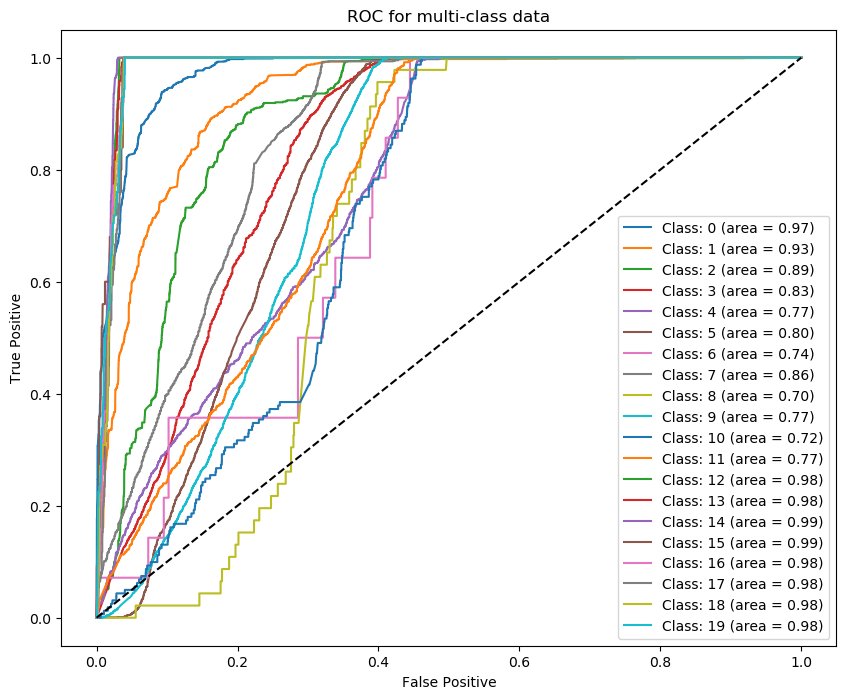

In [497]:
Y_train_predicted = predict(X_train, params)

# Y_train_code = convertYToMaxValuePerRecord(Y_train)
# Y_train_predicted_code = convertYToMaxValuePerRecord(Y_train_predicted)
printMetrics(Y_train, Y_train_predicted)
# trainReport = skm.classification_report(Y_train_code, Y_train_predicted_code)

# print(trainReport)
# plot_multiclass_roc(Y_train, Y_train_predicted, 20)


              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1866
           1       0.54      0.68      0.60       725
           2       0.00      0.00      0.00       224
           3       0.00      0.00      0.00       371
           4       0.00      0.00      0.00       195
           5       0.25      0.92      0.40       664
           6       0.00      0.00      0.00         6
           7       0.37      0.16      0.23       556
           8       0.00      0.00      0.00        20
           9       0.00      0.00      0.00       639
          10       0.00      0.00      0.00        58
          11       0.00      0.00      0.00       158
          12       0.24      0.65      0.35        68
          13       0.00      0.00      0.00        33
          14       0.28      0.32      0.30        76
          15       0.00      0.00      0.00         9
          16       0.00      0.00      0.00        11
          17       0.00    

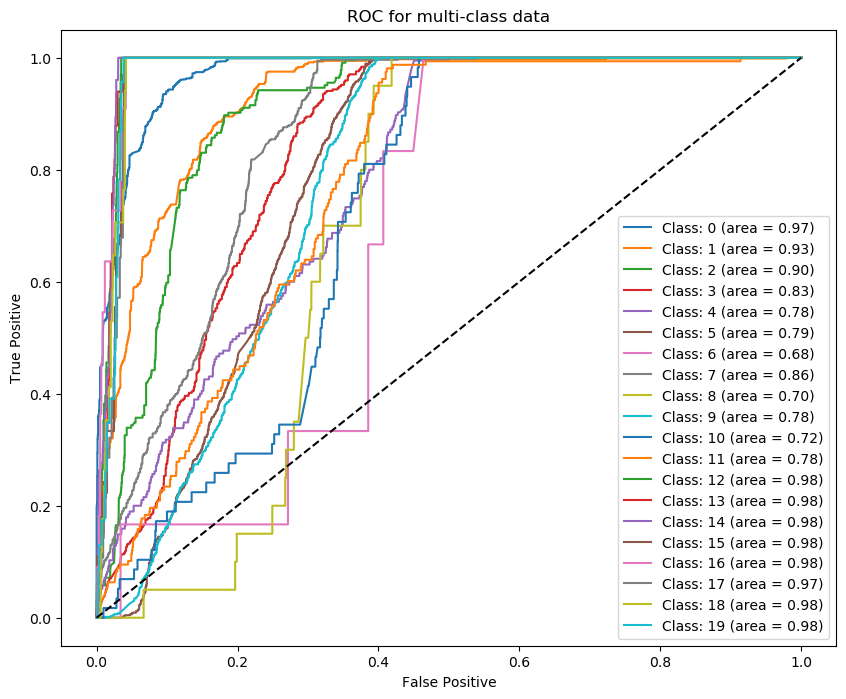

In [491]:
Y_test_predicted = predict(X_test, params)

Y_test_code = convertYToMaxValuePerRecord(Y_test)
Y_test_predicted_code = convertYToMaxValuePerRecord(Y_test_predicted)
testReport = skm.classification_report(Y_test_code, Y_test_predicted_code)
print(testReport)
plot_multiclass_roc(Y_test, Y_test_predicted, 20)

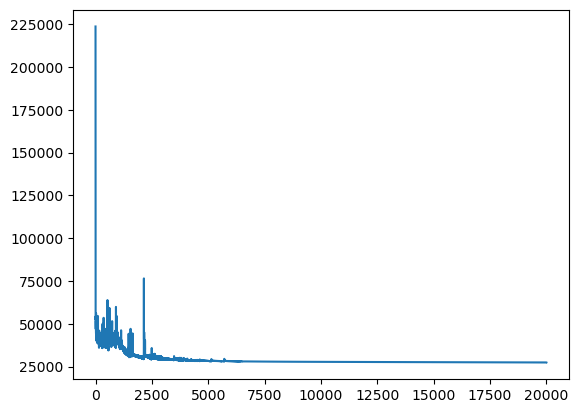

In [472]:
plt.plot(costs)

In [552]:
def runTests(alphasToTest, iterations, nHs, numbersOfHiddenLayers, filename):
    X_test, Y_test, X_train, Y_train =getEncodedDatasets()
    # alphasToTest = [0.000001,0.00001, 0.0001]
    # iterations = 5000
    nX = 2
    # nHs = [1,2,5,10,15,20,25,30,100,[5,10],[5,15],[10,20],[20,80],[15,5],[6,10,15]]
    nY = 20
    # numbersOfHiddenLayers = [1,1,1,1,1,1,1,1,1,2,2,2,2,2,3]
    if len(nHs) != len(numbersOfHiddenLayers):
        raise ValueError
    with open(filename, 'w', newline='') as fileHandle:
        writeFileHeader(fileHandle)
        for i in range(len(nHs)):
            for alpha in alphasToTest:
                nH = nHs[i]
                numberOfHiddenLayers = numbersOfHiddenLayers[i]
                parameters = initializeParameters(nX, nH, nY,numberOfHiddenLayers)
            
                params, costs = optimize(X_train,Y_train, parameters, alpha, iterations, False)
                Y_train_predicted = predict(X_train, params)
                Y_train_code = convertYToMaxValuePerRecord(Y_train)
                Y_train_predicted_code = convertYToMaxValuePerRecord(Y_train_predicted)
                trainReport = skm.classification_report(Y_train_code, Y_train_predicted_code, output_dict=True)
                Y_test_predicted = predict(X_test, params)
                Y_test_code = convertYToMaxValuePerRecord(Y_test)
                Y_test_predicted_code = convertYToMaxValuePerRecord(Y_test_predicted)
                testReport = skm.classification_report(Y_test_code, Y_test_predicted_code, output_dict=True)
                appendRow(fileHandle, testReport, trainReport, alpha, nH, costs[-1],iterations)



In [559]:
alphasToTest = [0.000001,0.00001, 0.0001]
iterations = 5000
nX = 2
nHs = [1,2,5,10,15,20,25,30,100,[20,20],[5,10],[5,15],[10,20],[20,80],[15,5],[6,10,15],[50,50,50]]
nY = 20
numbersOfHiddenLayers = [1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,3,3]
runTests(alphasToTest, iterations, nHs, numbersOfHiddenLayers, 'results3.csv')

In [560]:
def printTableFromCsv(filePath):
    df = pd.read_csv(filePath)
    df = df.sort_values(by=['Test Accuracy'], ascending=False)
    print(df.to_string(index=False))

In [561]:
printTableFromCsv('results3.csv')

   Alpha           nH          Cost  Iterations  Test Accuracy  Test Precision  Test Recall  Test F1-Score  Test Support  Train Accuracy  Train Precision  Train Recall  Train F1-Score  Train Support
0.000001 [50, 50, 50]  28046.130530        5000       0.526014        0.426854     0.526014       0.452450        5747.0        0.515834         0.412512      0.515834        0.440967        22988.0
0.000001           30  29624.138750        5000       0.511919        0.433154     0.511919       0.429499        5747.0        0.508178         0.429156      0.508178        0.425159        22988.0
0.000010           10  28243.567090        5000       0.510179        0.413385     0.510179       0.425867        5747.0        0.506090         0.406795      0.506090        0.420463        22988.0
0.000010           15  28393.190846        5000       0.510005        0.418732     0.510005       0.423268        5747.0        0.503654         0.401236      0.503654        0.415802        22988.0
0.000